# Mini challenge - NPM3D

## Imports

In [17]:
from datetime import datetime

import numpy as np
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import jaccard_score, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

from src import FeaturesExtractor, timeit, checkpoint, write_ply, smooth_labels

In [18]:
# paths of the training and test files
training_path = "./data/training"
test_path = "./data/test"
# choosing MiniLille1 as our validation set because it is the smallest
validation_point_cloud = "MiniLille1.ply"

In [19]:
features_extractor = FeaturesExtractor()

## Model selection

In [20]:
def choose_model(model: str):
    if model == "sklearn":
        return RandomForestClassifier()
    elif model == "lgbm":
        return LGBMClassifier(num_leaves=217)
    elif model == "xgboost":
        return XGBClassifier()
    else:
        raise ValueError("Incorrect model name passed")

In [21]:
model_name = "lgbm"  # @param
clf = choose_model(model_name)

## Pipelines

In [33]:
@timeit
def save_prediction(
    model,
    test_data_path: str,
    file_path: str = f"submissions/{model_name}-{datetime.now().strftime('%Y_%m_%d-%H_%M')}.txt",
    enable_smoothing: bool = True,
) -> None:
    timer = checkpoint()
    test_features = features_extractor.extract_features_no_label(test_data_path)
    timer("Time spent computing test features")

    predicted_labels = model.predict(test_features)
    timer("Time spent on test prediction")

    if enable_smoothing:
        point_cloud = features_extractor.extract_point_cloud_no_label(test_path)
        smooth_labels(point_cloud, predicted_labels, .2, len(features_extractor.label_names))
        timer("Time spent smoothing the features")

    assert predicted_labels.shape[0] == 3079187, "Incorrect number of predictions"

    if model_name == "xgboost":
        predicted_labels += 1

    np.savetxt(
        file_path,
        predicted_labels,
        fmt="%d",
    )
    timer(f"Time spent writing results on {file_path}")

In [23]:
@timeit
def test(
    predicted_labels: np.ndarray,
    test_labels: np.ndarray,
    point_cloud: np.ndarray,
    file_path: str = f"submissions/point_clouds/{model_name}-{datetime.now().strftime('%Y_%m_%d-%H_%M')}.ply",
) -> None:
    print(f"Accuracy:      {accuracy_score(test_labels, predicted_labels) * 100:.2f}%")
    print(
        f"Jaccard score: {jaccard_score(test_labels, predicted_labels, average='micro'):.4f}"
    )
    ConfusionMatrixDisplay.from_predictions(test_labels, predicted_labels)

    if len(point_cloud) == len(predicted_labels):
        write_ply(
            file_path,
            [
                point_cloud,
                predicted_labels,
                test_labels,
            ],
            ["x", "y", "z", "predicted_label", "true_label"],
        )

## Experiments

## Testing the model with one point cloud for validation

In [24]:
%%time
test_point_cloud = features_extractor.extract_point_clouds(
    training_path, validation_point_cloud
)[2]


Reading file MiniParis1.ply
1210261 elements available for class Ground
1071599 elements available for class Building
24787 elements available for class Poles
32396 elements available for class Pedestrians
50468 elements available for class Cars
1455156 elements available for class Vegetation

Reading file MiniLille1.ply
767722 elements available for class Ground
864939 elements available for class Building
5532 elements available for class Poles
0 elements available for class Pedestrians
114237 elements available for class Cars
104182 elements available for class Vegetation

Reading file MiniLille2.ply
1074040 elements available for class Ground
1000935 elements available for class Building
13094 elements available for class Poles
0 elements available for class Pedestrians
96132 elements available for class Cars
261365 elements available for class Vegetation
CPU times: user 224 ms, sys: 82.6 ms, total: 307 ms
Wall time: 367 ms


In [25]:
%%time
use_whole_point_cloud_for_validation = True
train_features, train_labels = features_extractor.extract_features(training_path)

if use_whole_point_cloud_for_validation:
    print(f"Using point cloud {validation_point_cloud} as validation set.")
    # the line below does not require computing the features again since they are cached
    X_train, y_train, X_val, y_val = features_extractor.extract_features(
        training_path, validation_point_cloud
    )
else:
    print(f"Splitting the training point clouds between training and validation.")
    X_train, X_val, y_train, y_val = train_test_split(
        train_features, train_labels, test_size=0.2, random_state=42
    )


Reading file MiniParis1.ply
Using cached features and labels

Reading file MiniLille1.ply
Using cached features and labels

Reading file MiniLille2.ply
Using cached features and labels
Using point cloud MiniLille1.ply as validation set.

Reading file MiniParis1.ply
Using cached features and labels

Reading file MiniLille1.ply
Using cached features and labels

Reading file MiniLille2.ply
Using cached features and labels
CPU times: user 163 ms, sys: 1.16 s, total: 1.33 s
Wall time: 2.15 s


In [26]:
if model_name == "xgboost":
    y_train -= 1
    y_train = y_train.astype(int)
    y_val -= 1
    y_val = y_val.astype(int)

In [27]:
%%time
clf.fit(X_train, y_train)

CPU times: user 5min 2s, sys: 19.5 s, total: 5min 21s
Wall time: 1min 18s


LGBMClassifier(num_leaves=217)

In [28]:
print(f"Training set score: {clf.score(X_train, y_train):.4f}")
print(f"Test set score: {clf.score(X_val, y_val):.4f}")

Training set score: 1.0000
Test set score: 0.8779


Accuracy:      87.79%
Jaccard score: 0.7824
Function test took 0.25 seconds
CPU times: user 17.1 s, sys: 106 ms, total: 17.2 s
Wall time: 2.95 s


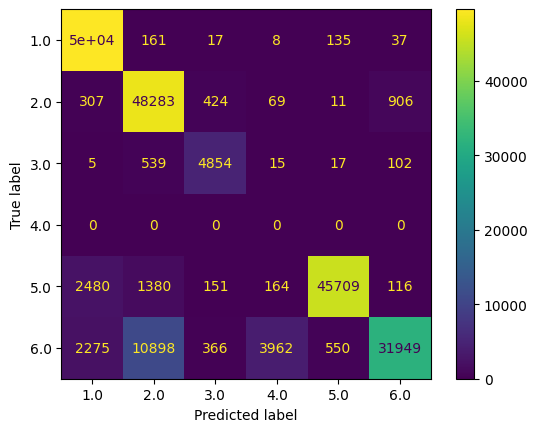

In [29]:
%%time
prediction = clf.predict(X_val)
test(prediction, y_val, test_point_cloud)

150823 points unvisited.
1 points visited.

150822 points unvisited.
1 points visited.

150821 points unvisited.
1 points visited.

150820 points unvisited.
1 points visited.

150819 points unvisited.
1 points visited.

150818 points unvisited.
1 points visited.

150817 points unvisited.
1 points visited.

150816 points unvisited.
1 points visited.

150815 points unvisited.
1 points visited.

150814 points unvisited.
1 points visited.

150813 points unvisited.
1 points visited.

150812 points unvisited.
1 points visited.

150811 points unvisited.
1 points visited.

150810 points unvisited.
1 points visited.

150809 points unvisited.
1 points visited.

150808 points unvisited.
1 points visited.

150807 points unvisited.
1 points visited.

150806 points unvisited.
1 points visited.

150805 points unvisited.
1 points visited.

150804 points unvisited.
1 points visited.

150803 points unvisited.
1 points visited.

150802 points unvisited.
1 points visited.

150801 points unvisited.
1 point

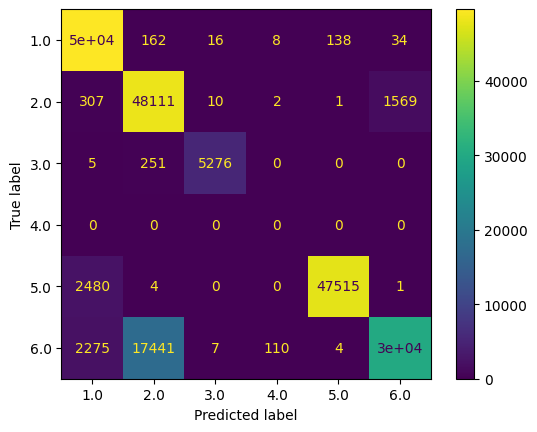

In [14]:
%%time
smooth_labels(test_point_cloud, prediction, 0.3, len(features_extractor.label_names))
test(
    prediction,
    y_val,
    test_point_cloud,
    file_path=f"submissions/point_clouds/{model_name}_smooth-{datetime.now().strftime('%Y_%m_%d-%H_%M')}.ply",
)

## Training the model on all three point clouds

## Cross validation

In [26]:
perform_cross_val = False  # @param

if perform_cross_val:
    from sklearn.model_selection import GridSearchCV, StratifiedKFold

    gkf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42).split(
        X=X_train, y=y_train
    )

    if model_name == "lgbm":
        param_grid = {
            "learning_rate": [1e-2],
            "num_leaves": [217],
            # "reg_alpha": [0.],
            "reg_lambda": [0.0, 0.5],
            # "min_child_samples": [18, 20],
            # "min_child_weight": [5e-4, 1e-3],
        }
    elif model_name == "sklearn":
        param_grid = {
            "learning_rate": [1e-2],
            "num_leaves": [103, 147],
        }
    # 0.991, 217
    gsearch = GridSearchCV(
        estimator=clf, param_grid=param_grid, cv=gkf, n_jobs=1, verbose=42
    )
    lgb_model = gsearch.fit(X=X_train, y=y_train)

    print(lgb_model.best_params_, lgb_model.best_score_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3; 1/2] START learning_rate=0.01, num_leaves=217, reg_lambda=0.0..........
[CV 1/3; 1/2] END learning_rate=0.01, num_leaves=217, reg_lambda=0.0;, score=0.991 total time= 1.5min
[CV 2/3; 1/2] START learning_rate=0.01, num_leaves=217, reg_lambda=0.0..........
[CV 2/3; 1/2] END learning_rate=0.01, num_leaves=217, reg_lambda=0.0;, score=0.990 total time=115.1min
[CV 3/3; 1/2] START learning_rate=0.01, num_leaves=217, reg_lambda=0.0..........
[CV 3/3; 1/2] END learning_rate=0.01, num_leaves=217, reg_lambda=0.0;, score=0.991 total time=129.6min
[CV 1/3; 2/2] START learning_rate=0.01, num_leaves=217, reg_lambda=0.5..........
[CV 1/3; 2/2] END learning_rate=0.01, num_leaves=217, reg_lambda=0.5;, score=0.991 total time=143.7min
[CV 2/3; 2/2] START learning_rate=0.01, num_leaves=217, reg_lambda=0.5..........
[CV 2/3; 2/2] END learning_rate=0.01, num_leaves=217, reg_lambda=0.5;, score=0.990 total time=61.4min
[CV 3/3; 2/2] START lea

In [30]:
%%time
clf.fit(train_features, train_labels)

CPU times: user 8min 22s, sys: 30.9 s, total: 8min 53s
Wall time: 1min 44s


LGBMClassifier(num_leaves=217)

In [34]:
save_prediction(clf, test_path)


Reading file MiniDijon9.ply
Using cached features
Time spent computing test features: 1497.39 seconds
Time spent on test prediction: 31.57 seconds

Reading file MiniDijon9.ply
1743448 points unvisited.
457647 points visited.

1285801 points unvisited.
686961 points visited.

598840 points unvisited.
6321 points visited.

592519 points unvisited.
1753 points visited.

590766 points unvisited.
443 points visited.

590323 points unvisited.
2513 points visited.

587810 points unvisited.
7711 points visited.

580099 points unvisited.
20512 points visited.

559587 points unvisited.
45576 points visited.

514011 points unvisited.
8068 points visited.

505943 points unvisited.
9546 points visited.

496397 points unvisited.
4241 points visited.

492156 points unvisited.
10668 points visited.

481488 points unvisited.
1982 points visited.

479506 points unvisited.
18876 points visited.

460630 points unvisited.
13141 points visited.

447489 points unvisited.
29991 points visited.

417498 points

Remove ground and perform region growing + majority vote (class importance in vote can be learning).